In [1]:
import tensorflow as tf
import numpy as np
import pickle
import os
from matplotlib import pyplot as plt

In [2]:
# Loading the CIFAR10 Dataset

In [3]:
class CifarLoader(object):
    def __init__(self, source_files):
        self._source = source_files
        self._i = 0
        self.images = None
        self.labels = None
        
    def load(self):
        data = [unpickle(f) for f in self._source]
        images = np.vstack([d["data"] for d in data])
        n = len(images)
        self.images = images.reshape(n, 3, 32,32).transpose(0, 2, 3, 1).astype(float)/255
        self.labels = one_hot(np.hstack([d["labels"] for d in data]), 10)
        return self
        
    def next_batch(self, batch_size):
        x, y = self.images[self._i:self._i+batch_size], self.labels[self._i:self._i+batch_size]
        self._i = (self._i + batch_size) % len(self.images)
        return x, y

In [4]:
DATA_PATH = r"C:\Users\Zhao-hangtian\cifar-10-batches-py"

In [5]:
def unpickle(file):
    with open(os.path.join(DATA_PATH, file), 'rb') as fo:
        dict = pickle.load(fo,encoding='latin1')
    return dict

In [6]:
def one_hot(vec, vals=10):
    n = len(vec)
    out = np.zeros((n,vals))
    out[range(n),vec] = 1
    return out

In [7]:
class CifarDataManager(object):
    def __init__(self):
        self.train = CifarLoader(["data_batch_{}".format(i)for i in range(1,6)]).load()
        self.test = CifarLoader(["test_batch"]).load()
            

In [8]:
def display_cifar(images, size):
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()
    im = np.vstack([np.hstack(images[np.random.choice(n)] for i in range(size)) for i in range(size)])
    plt.imshow(im)
    plt.show()

Number of train images: 50000
Number of train labels: 50000
Number of test images: 10000
Number of test labels: 10000


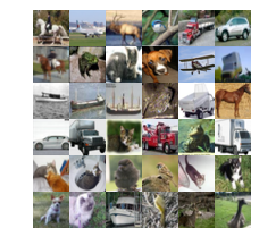

In [9]:
d = CifarDataManager()
print("Number of train images: {}".format(len(d.train.images)))
# print(d.train.images,d.train.labels)
print("Number of train labels: {}".format(len(d.train.labels)))
print("Number of test images: {}".format(len(d.test.images)))
print("Number of test labels: {}".format(len(d.test.labels)))
images = d.train.images
display_cifar(images, 6)

In [10]:
# Simple CIFAR10 Models

In [11]:
cifar = CifarDataManager()

In [33]:
NUM_STEPS = 1500
MINIBATCH_SIZE = 500

In [34]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def conv_layer(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input, W) + b)

def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = weight_variable([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W) + b

In [35]:
C1, C2, C3 = 30, 50, 80
F1 = 500

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

conv1_1 = conv_layer(x, shape=[3, 3, 3, C1])
conv1_2 = conv_layer(conv1_1, shape=[3, 3, C1, C1])
conv1_3 = conv_layer(conv1_2, shape=[3, 3, C1, C1])
conv1_pool = max_pool_2x2(conv1_3)
conv1_drop = tf.nn.dropout(conv1_pool, keep_prob=keep_prob)

conv2_1 = conv_layer(conv1_drop, shape=[3, 3, C1, C2])
conv2_2 = conv_layer(conv2_1, shape=[3, 3, C2, C2])
conv2_3 = conv_layer(conv2_2, shape=[3, 3, C2, C2])
conv2_pool = max_pool_2x2(conv2_3)
conv2_drop = tf.nn.dropout(conv2_pool, keep_prob=keep_prob)

conv3_1 = conv_layer(conv2_drop, shape=[3, 3, C2, C3])
conv3_2 = conv_layer(conv3_1, shape=[3, 3, C3, C3])
conv3_3 = conv_layer(conv3_2, shape=[3, 3, C3, C3])
conv3_pool = tf.nn.max_pool(conv3_3, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME')
conv3_flat = tf.reshape(conv3_pool, [-1, C3])
conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)

full_1 = tf.nn.relu(full_layer(conv3_drop, F1))
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 10)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv,labels=y_))

train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [36]:
def test(sess):
    X = cifar.test.images.reshape(10, 1000, 32, 32, 3)
    Y = cifar.test.labels.reshape(10, 1000, 10)
    acc = np.mean([sess.run(accuracy, feed_dict={x:X[i], y_:Y[i], keep_prob: 1.}) \
                  for i in range(10)])
    print("Accuracy: {:.4}%".format(acc * 100))

X = cifar.train.images.reshape(10, 5000, 32, 32, 3)
Y = cifar.train.labels.reshape(10, 5000, 10)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(NUM_STEPS):
        batch = cifar.train.next_batch(MINIBATCH_SIZE)
        sess.run(train_step, feed_dict={x:batch[0], y_:batch[1], keep_prob: .5})
        
    test(sess)

Accuracy: 48.28%
